# Coding Assignment 3

CS 598 Practical Statistical Learning

2023-10-09

UIUC Fall 2023

**Authors**
* Ryan Fogle
    - rsfogle2@illinois.edu
    - UIN: 652628818
* Sean Enright
    - seanre2@illinois.edu
    - UIN: 661791377

**Contributions**

TODO

## Part I

Here we implement LOO-CV and GCV to select the optimal span for LOESS.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

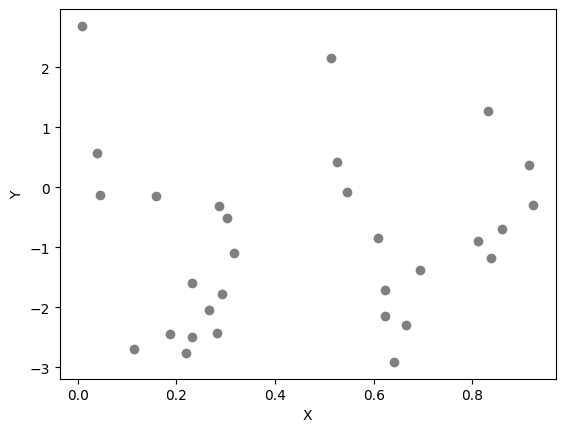

In [7]:
data_part1 = pd.read_csv("Coding3_Data.csv")

fig, ax = plt.subplots()
ax.scatter(data_part1['x'], data_part1['y'], color='grey')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()
